# Backtesting of predctions

## Author: Danilo Filippo Reiszel Pereira
Univesidade Federal do Rio de Janeiro

This notebook contains the creation a Multi-layer Perceptron model to predict D+1 closing prices of PETR4 stocks, using as input 10 delays of its return series and some auxiliary series, with backtesting of the predictions

In [84]:
from __future__ import print_function, division
import sys, os
sys.path.append('../../../../src')
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralstocks.dataacquisition import *
from neuralstocks.plots import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

%matplotlib inline

# Global Params
Setting global params and useful variables, such as directories and image styling

In [2]:
pathPETR4 = '../../../../../data/stocks/PETR4/diario/PETR4.CSV'
pathIBOV = '../../../../../data/indexes/IBOV/diario/IBOV.CSV'
pathUSDBRL = '../../../../../data/forex/USDBRL/diario/USDBRL.CSV'

decomposeModel = 'additive'

saveVarDir = './Variables'
os.makedirs(saveVarDir) if not os.path.exists(saveVarDir) else print('')

saveFigDir = './Figures'
os.makedirs(saveFigDir) if not os.path.exists(saveFigDir) else print('')

saveModelDir = './Models'
os.makedirs(saveModelDir) if not os.path.exists(saveModelDir) else print('')

saveImgFormat = 'png'

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

## Data Acquisition and Preprocessing

Gathers and preprocess data. Data from auxiliary time series (such as IBOV index and USDBRL exchange rate) is also gathered, though tipically less indicators are calculated for this series. Trend Extraction is applied to desired series.

<strong>List of indicators applied to main time series: </strong>
<ul>
    <li>Mean and Standard Deviation, 20 periods</li>
    <li>Returns Calculations:
        <ul>
            <li>Close<sub>d</sub> / Close<sub>d-1</sub></li>
            <li>Close<sub>d</sub> / Open<sub>d</sub></li>
            <li>High<sub>d</sub> / Close<sub>d</sub></li>
            <li>Low<sub>d</sub> / Close<sub>d</sub></li>
        </ul>
    </li>
    <li>EMAs:
        <ul>
            <li>Close, 17 periods</li>
            <li>Close, 72 periods</li>
            <li>Close, 200 periods</li>
            <li>Volume, 21 periods</li>
        </ul>
    </li>
    <li>MACD, fast EMA = 12 periods, slow EMA = 26 periods, signal EMA = 9 periods</li>
    <li>Bollinger Bands, 20 periods</li>
    <li>On-Balance Volume (OBV)</li>
</ul>

In [3]:
init_time = time.time()
PETR4 = acquireData(filePath = pathPETR4,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], ['Close', 'Open'], ['High', 'Close' ], ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}, 
                                 {'column': 'Volume', 'lenght': 21}],
                    MACDParams = [{'fast_lenght': 12, 'slow_lenght': 26, 'signal_lenght': 9}],
                    BBParams = [{'lenght': 20}],
                    OBVParams = [{'lenght': None}],
                    colPrefix = 'PETR4',
                    dropNan = True
                   )

IBOV = acquireData(filePath = pathIBOV,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], ['Close', 'Open'], ['High', 'Close' ], ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'IBOV',
                    dropNan = True
                  )

USDBRL= acquireData(filePath = pathUSDBRL,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], ['Close', 'Open'], ['High', 'Close' ], ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'USDBRL',
                    dropNan = True
                   )


end_time = time.time()
print('Time to acquire and process data: '+str(end_time-init_time)+' seconds')

Time to acquire and process data: 5.48707914352 seconds


## Dataset concatenation and selection of wich features to feed to the model

In [4]:
df = pd.concat([PETR4, IBOV, USDBRL], axis = 1).dropna()

columnsToUse = [ 
                'PETR4_Close_rollStd20', 
                'PETR4_Close_returns', 'PETR4_Close/Open_returns', 'PETR4_High/Close_returns', 'PETR4_Low/Close_returns', 
                'PETR4_Close_EMA17_logdiff', 'PETR4_Close_EMA72_logdiff', 'PETR4_Close_EMA200_logdiff', 'PETR4_Volume_EMA21_logdiff', 
                'PETR4_MACD_12_26_9', 'PETR4_MACDsignal_12_26_9', 'PETR4_Bollinger%b_20', 'PETR4_OBV', 
                'PETR4_Holiday'
               ]

## Creation of feature matrix and output array, split of data in Train, Validation and Test sets
All data from 2017 is used as Test set, reamining data is split into train and validation according to *validationSplitSize*

In [5]:
xTrain, yTrain, xVal, yVal, xTest, yTest = prepData(df = df, 
                                                    columnsToUse = columnsToUse, 
                                                    columnToPredict = 'PETR4_Close_returns', 
                                                    nDelays = 10, 
                                                    testSetSize = len(df['2017']), 
                                                    validationSplitSize = 0.15)

print('Number of train batches: {}'.format(len(xTrain)))
print('Number of validation batches: {}'.format(len(xVal)))
print('Number of test batches: {}'.format(len(xTest)))
print('Number of inputs per batch: {}'.format(len(xTrain[0])))

Number of train batches: 3557
Number of validation batches: 628
Number of test batches: 175
Number of inputs per batch: 23


## Feature Scalling

In [6]:
xNormScaler = MinMaxScaler(feature_range = (-1,1))
xNormScaler.fit(np.append(xTrain, xVal, axis = 0))

yNormScaler = MinMaxScaler(feature_range = (-1,1))
yNormScaler.fit(np.append(yTrain, yVal, axis = 0))

xNormTrain = xNormScaler.transform(xTrain)
xNormVal = xNormScaler.transform(xVal)
xNormTest  = xNormScaler.transform(xTest)

yNormTrain = yNormScaler.transform(yTrain)
yNormVal = yNormScaler.transform(yVal)

## Finding the best hidden layer

In [15]:
bestNormHiddenLayer = 7

bestNormModel = load_model('./Models/PETR4returns_MLPi23h{}_norm.h5'.format(bestNormHiddenLayer))
bestNormModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 8)                 192       
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 9         
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


## Reconstruction of the time series using predicted values

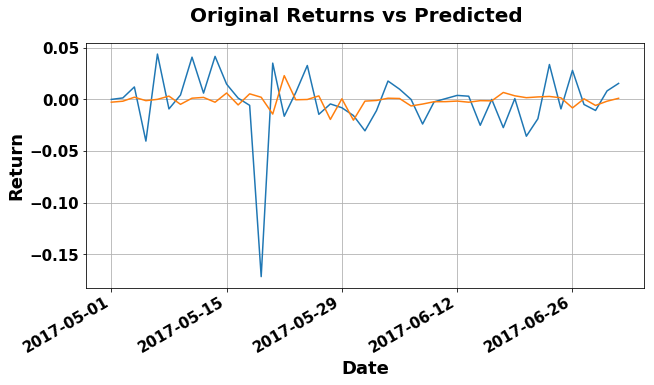

In [17]:
predictions = bestNormModel.predict(xNormTest)
predictions = yNormScaler.inverse_transform(predictions)
predictions_clean = []
for p in predictions:
    predictions_clean.extend(p)
predictionsSeries = pd.Series(predictions_clean, index = df['2017'].index)

fig, ax = plotSeries([df['PETR4_Close_returns'], predictionsSeries],
                     initialPlotDate = '2017-05', finalPlotDate = '2017-06',
                     title = 'Original Returns vs Predicted', ylabel = 'Return')

(<matplotlib.figure.Figure at 0x7f2dcb5b7cd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2dcb3c3490>)

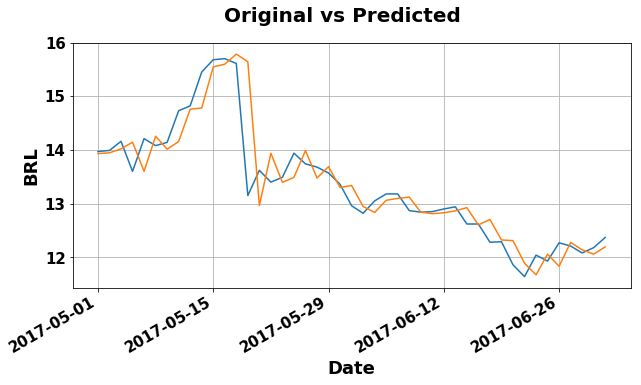

In [18]:
predicted = reconstructReturns(df['PETR4_Close'], predictionsSeries)

plotSeries([df['PETR4_Close'], predicted],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original vs Predicted', ylabel = 'BRL')

In [191]:
from __future__ import division
import random
from collections import defaultdict

class Backtest:
    dailyData = {}
    history = {}
    verbose = 0;
    
    stopLoss = None
    stopGain = None
    maxExposure = None
    maxTotalExposure = None
    openOperations = []
    
    def __init__(self, assets, dataPath = '../../../data/stocks/[asset]/diario/[asset].CSV', funds = 100000, 
                 brokerage = 6.0, transactionFees = 0.000325, ISStax = 0.05):
        self.assets = assets
        self.dataPath = dataPath
        self.funds = funds
        self.brokerage = brokerage
        self.transactionFees = transactionFees
        self.ISStax = ISStax
        
        self.loadData()
        
    def setRiskManagement(self, stopLoss = None, stopGain = None, maxExposure = None, maxTotalExposure = None):
        self.stopLoss = stopLoss
        self.stopGain = stopGain
        self.maxExposure = maxExposure
        self.maxTotalExposure = maxTotalExposure
        
    def loadData(self):
        for asset in self.assets:
            filePath = self.dataPath.replace('[asset]', asset)
            df = pd.read_csv(filePath, delimiter=';', decimal=',',
                     parse_dates=['Date'], dayfirst=True, index_col='Date').sort_index()
            self.dailyData[asset] = df
        
    def createOperation(self, asset, opType, volume, price):
        return {'asset': asset, 'opType': opType, 'volume': volume, 'price': price}
    
    def simulate(self, funds = None, strategy='buy-n-hold', start = None, end = None, longOnly = False, predicted = None, verbose = 0):
        self.funds = funds if funds else self.funds
        self.verbose = verbose
        if predicted:
            for asset in assets:
                self.dailyData[asset] = pd.concat([self.dailyData[asset], predicted[asset]], axis = 1)
        if strategy == 'buy-n-hold':
            self.buyNHold(start, end)
        else:
            pass
            #for i in range(len(predicted)):
    
    def buyNHold(self, start, end):
        maxValue = self.funds / len(self.assets)
        random.shuffle(self.assets)
        print('Portfolio value: {}'.format(self.funds))
        for asset in self.assets:
            self.buy(asset = asset, day = self.dailyData[asset][start:end].index[0], limitValue = maxValue)
        for asset in self.assets:
            self.sell(asset = asset, day = self.dailyData[asset][start:end].index[-1])
        print('Portfolio value: {}'.format(self.funds))
    
                
    def buy(self, asset, day, volume = None, limitValue = None):
        price = self.dailyData[asset]['Open'][day]
        if not volume and not limitValue:
            print('{} - Error buying {} - Neither volume nor limitValue were specified'.format(day, asset))
        else:
            limitVolume = int(((limitValue/price)//100)*100)
            volume = volume if volume else limitVolume
            buyValue = volume * price
            fees = self.brokerage + (buyValue * self.transactionFees) + (self.brokerage * self.ISStax)
            self.openOperations.append(self.createOperation(asset, 'long', volume, price))
            self.funds -= (buyValue + fees)
            if self.verbose >= 2:
                print('{} Open - Bought {} {}. price: {}, fees: {:.2f}, total: {:.2f}'.format(day.strftime('%Y-%m-%d'), volume, asset, price, fees, buyValue + fees))
                
    def sell(self, asset, day):
        operation = self.openOperations.pop(findIndex(self.openOperations, asset, lambda x, y: x['asset'] == y))
        volume = operation['volume']
        price = self.dailyData[asset]['Close'][day]
        sellValue = volume * price
        fees = self.brokerage + (sellValue * self.transactionFees) + (self.brokerage * self.ISStax)
        self.funds += (sellValue - fees)
        if self.verbose >= 2:
            print('{} Close - Sold {} {}. price: {}, fees: {:.2f}, total: {:.2f}'.format(day.strftime('%Y-%m-%d'), volume, asset, price, fees, sellValue + fees))
    
class Operation:
    op_index = defaultdict(list)
    
    def __init__(self, asset, opType, volume, price):
        self.asset = asset
        self.opType = opType
        self.volume = volume
        self.price = price
        Operation.op_index[asset].append(self)
        
    @classmethod
    def findByAsset(cls, asset):
        return Operation.op_index[asset]
    
def findIndex(array, obj, func):
    for i in range(len(array)):
        if func(array[i], obj):
            return i
    return -1

In [192]:
bt = Backtest(assets = ['PETR4', 'ITUB4', 'VALE5'], dataPath = '../../../../../data/stocks/[asset]/diario/[asset].CSV')

In [193]:
bt.simulate(verbose = 2, start = '2017')

Portfolio value: 100000
2017-01-02 Open - Bought 1000 ITUB4. price: 32.53, fees: 16.87, total: 32546.87
2017-01-02 Open - Bought 1400 VALE5. price: 22.27, fees: 16.43, total: 31194.43
2017-01-02 Open - Bought 2200 PETR4. price: 14.64, fees: 16.77, total: 32224.77
2017-09-01 Close - Sold 1000 ITUB4. price: 41.18, fees: 19.68, total: 41199.68
2017-09-01 Close - Sold 1400 VALE5. price: 33.07, fees: 21.35, total: 46319.35
2017-09-01 Close - Sold 2200 PETR4. price: 14.02, fees: 16.32, total: 30860.32
Portfolio value: 122298.57265
